Тест проводился 25 мая - 25 июня 2023.

Здесь представлен пример расчета АБ теста с CUPED

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from data_utils.vertica_utils import Vertica
import getpass
vert = Vertica(account='srv_pvz_post_team', password=getpass.getpass(prompt='Enter your Vertica password: '), host='prod')

Enter your Vertica password:  ········


In [2]:
from datetime import date, timedelta
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from random import choice

## 1. Собираем данные за последний и предпоследний месяц перед началом эксп-та:

In [32]:
end = pd.Timestamp('25-May-2023')
start = end - timedelta(days=30)

In [68]:
%%time

q = \
"""
SELECT 
FactDate,
itemdeliveryid as id_cd,
SUM (CASE WHEN A.ActionTypeID = 401 THEN A.SalesCommercial WHEN A.ActionTypeID IN (402, 403) THEN - A.SalesCommercial ELSE 0 END) as gmv
FROM metazonbeeeye.action AS a
JOIN (select distinct id_cd, delivery_type from CA_team.Lastmile_dv_daily) AS d
ON d.id_cd = a.itemdeliveryid
WHERE delivery_type IN ('АПВЗ Brand - 4.4%', 'АПВЗ Brand - 3.5%', 'СПВЗ', 'Домашний ПВЗ')
AND FactDate < '2023-05-25' AND FactDate > '2023-03-25'
GROUP BY 1,2
"""

data = vert.read(q)
data['gmv'] = data['gmv'].astype(float)

CPU times: user 16 s, sys: 560 ms, total: 16.5 s
Wall time: 44.5 s


In [69]:
data['period'] = data['FactDate'].apply(lambda x: 'prehistorical' if x<pd.Timestamp('25-Apr-2023') else 'historical')

In [70]:
data = data.groupby(['id_cd', 'period'], as_index=False).agg({"gmv":'sum'}).rename(columns={'gmv':'monthly_gmv'})

In [71]:
pivoted = data.pivot(index='id_cd', values='monthly_gmv', columns='period').dropna().reset_index()

In [72]:
# считаем θ:
x = pivoted['historical']
y = pivoted['prehistorical']
covariance = np.cov(x, y)[0, 1]
variance = x.var()
theta = covariance / variance

theta

0.9704053999250989

In [73]:
# получаем историческую cuped-метрику:

pivoted['cuped_historical'] = pivoted['historical'] - theta*(pivoted['prehistorical']-pivoted['prehistorical'].mean())

In [74]:
# проверяем средние исходной и CUPED метрики:
print(f"Среднее исходной метрики: {pivoted['historical'].mean():.0f}")
print(f"Среднее CUPED метрики: {pivoted['cuped_historical'].mean():.0f}")

Среднее исходной метрики: 2777326
Среднее CUPED метрики: 2777326


In [75]:
# проверяем дисперсию исходной и CUPED метрики:
print(f"Дисперсия исходной метрики: {pivoted['historical'].std():.0f}")
print(f"Дисперсия CUPED метрики: {pivoted['cuped_historical'].std():.0f}")

print(f"\nРазница в {pivoted['historical'].std()/pivoted['cuped_historical'].std():.2f} раза")

Дисперсия исходной метрики: 2784574
Дисперсия CUPED метрики: 799902

Разница в 3.48 раза


## Cчитаем min_sample_size:

In [76]:
import numpy as np
from scipy.stats import norm

def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(np.ceil(
        z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
    ))
    return sample_size

In [77]:
epsilon = pivoted['cuped_historical'].mean()*0.02 # mde
std = pivoted['cuped_historical'].std()  

min_sample_size = get_sample_size_abs(epsilon, std)
print(f"Минимальный размер выборки: {min_sample_size}")

Минимальный размер выборки: 3256


## Проводим синтетические АА и АБ тесты:

In [78]:
# ф-ция построения гистограмм:

def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

#### АА-тесты:

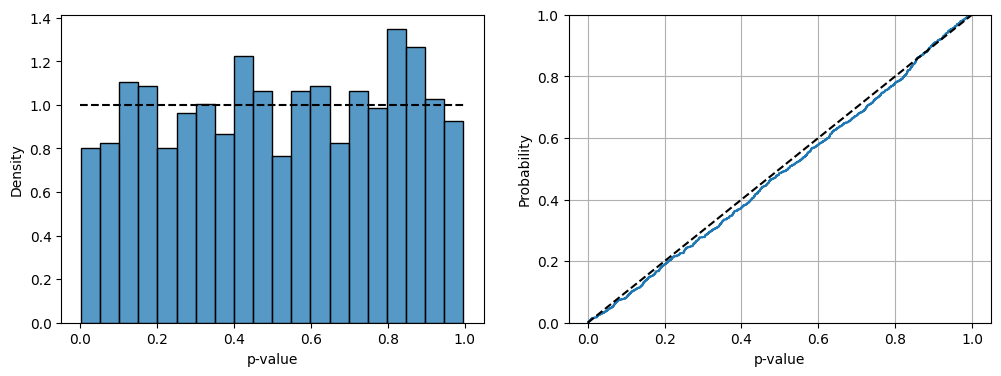

In [79]:
p_values = []

# Генерация данных и проведение t-теста
for _ in range(1000):
    
    sampled_data = pivoted.sample(2*min_sample_size)
    sampled_data['group'] = [choice(['test', 'control']) for i in range(len(sampled_data))]
    test = sampled_data[sampled_data['group']=='test']['cuped_historical']
    control = sampled_data[sampled_data['group']=='control']['cuped_historical']
    _, p_val = stats.ttest_ind(test, control, equal_var=False)
    p_values.append(p_val)
    
plot_pvalue_ecdf(p_values)

In [80]:
alpha = (pd.Series(p_values)<0.05).mean()
print(f'Вероятность ошибки первого рода: {alpha:.2f}') # должно быть <0.05

Вероятность ошибки первого рода: 0.04


#### АВ-тесты:

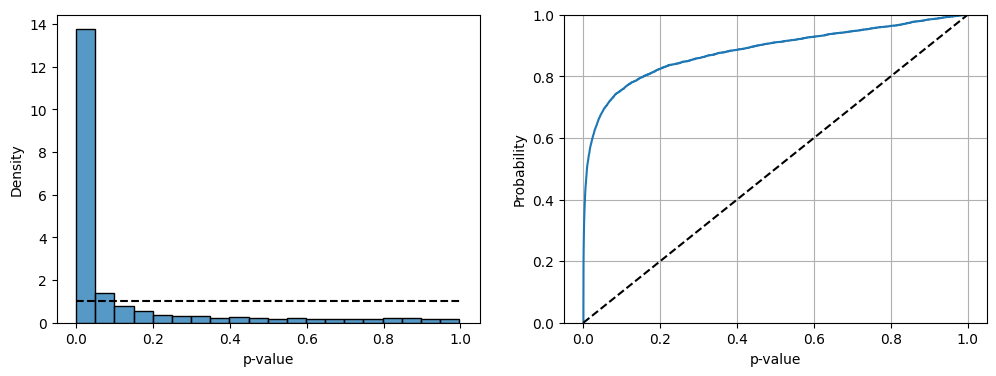

In [96]:
mde = pivoted['cuped_historical'].mean()*0.02

for _ in range(1000):

    sampled_data = pivoted.sample(2*min_sample_size)
    sampled_data['group'] = [choice(['test', 'control']) for i in range(len(sampled_data))]
    test = sampled_data[sampled_data['group']=='test']['cuped_historical']
    control = sampled_data[sampled_data['group']=='control']['cuped_historical'] + mde
    _, p_val = stats.ttest_ind(test, control, equal_var=False)
    p_values.append(p_val)
    
plot_pvalue_ecdf(p_values)

In [97]:
# кривая на правом графике должна проходить примерно через x=0.2, y=0.8 тогда норм 

In [98]:
beta = (pd.Series(p_values)>0.2).mean()
print(f'Вероятность ошибки второго рода: {beta:.2f}') # должно быть <0.2

Вероятность ошибки второго рода: 0.18
